<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=399f21e1343ef0d2ccb7f838a1d365eefaba3912dc47909b271f6c82a42e54aa
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [2]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [3]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [6]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(uniqueSampleNum, sampleNumber):

  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(uniqueSampleNum)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)
  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))

  fullGaussMatrix = np.repeat(gaussTotal,repeats=sampleNumber,axis=0)
  dataPoisson = np.random.poisson(lam=fullGaussMatrix,size=None)

  fullthetaData = np.repeat(thetaData,repeats=sampleNumber,axis=0)

  return dataPoisson, fullthetaData






In [ ]:
dataPoisson, thetaData = generateTrainingData(10000,1024)

In [55]:
print(dataPoisson.shape)
print(thetaData.shape)

(10240000, 10)
(10240000, 6)


In [7]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [8]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0


100%|██████████| 5/5 [03:24<00:00, 40.88s/it]

5


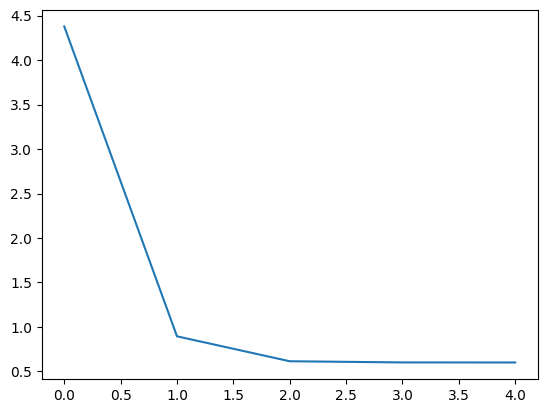

In [40]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)

In [42]:
print(r_losses[-1])

0.6012495519878628


[1.032324  2.9950016 0.9896828 6.9872613 5.0578628 2.4095361 1.8101711
 1.444435  1.2020389 1.0736494]
[1. 3. 1. 7. 5. 2. 3. 1. 2. 0.]


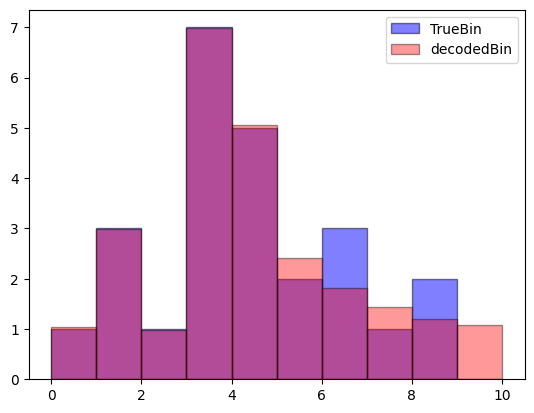

In [43]:
testP,_ = generateTrainingData(1,1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [9]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)


In [10]:
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-3)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         1,740
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         1,740
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         1,740
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         1,740
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        1,740
│    │    └─Rever

In [ ]:
batch_size = 512
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 100 == 0):
      print(f"nll:{cnf_loss}")

    cnf_loss.backward()
    flowOptim.step()





In [ ]:
plt.plot(logLoss,label="LogLoss")
plt.legend()
plt.show()

print(logLoss[-1])

In [ ]:
torch.save({
    "cnf": CNFModel.state_dict(),
    "optimizer": flowOptim.state_dict(),
}, "CNF_params_Optim.pth")

torch.save({
    "ae": encodeModel.state_dict(),\
    "AE_Optim": reconOptim.state_dict(),
}, "AE_params_Optim.pth")


In [ ]:
ckpt_AE  = torch.load("AE_params_Optim.pth", map_location=device)
ckpt_CNF = torch.load("CNF_params_Optim.pth", map_location=device)
encodeModel.load_state_dict(ckpt_AE["ae"])
CNFModel.load_state_dict(ckpt_CNF["cnf"])

encodeModel.eval()
CNFModel.eval()

In [13]:
cnfP, cnfT = generateTrainingData(1,500000)
cnfT = cnfT[0]
print(cnfP.nbytes)

cnfP_tensor = torch.tensor(cnfP,dtype = torch.float32)

batch_test = DataLoader(cnfP_tensor, batch_size = 4096)

40000000


In [14]:
testData = []

with torch.no_grad():
  for x_batch in batch_test:
    x = x_batch.to(device)
    cnfP_en = encodeModel.encode(x)
    samples = CNFModel.sample(1000,context=cnfP_en).cpu().numpy()
    sample_cut = samples.reshape(-1,samples.shape[-1])
    testData.append(sample_cut)


In [15]:
testnp = np.concatenate(testData,axis=0)
print(testnp.shape)

(500000000, 6)


In [16]:
print(testnp)

[[39.345776   2.6301916  1.087214  23.387293   6.250814   6.9984927]
 [47.09831    2.8063095  1.4434682 11.153182   9.6073885  5.377446 ]
 [39.533665   2.8437881  1.2018108 26.766485   6.810224   7.11374  ]
 ...
 [46.082138   3.0256782  1.597371  19.495045   6.682241   7.297448 ]
 [31.713634   2.959961   1.0718032 26.90112    6.794185   7.2055125]
 [46.93037    2.8717031  1.2520411 19.59943    6.312133   8.05328  ]]


In [25]:
N1_cnf = testnp[:,0]
mu1_cnf = testnp[:,1]
sig1_cnf = testnp[:,2]
N2_cnf = testnp[:,3]
mu2_cnf = testnp[:,4]
sig2_cnf = testnp[:,5]

In [26]:
print(cnfT)

[40.87367267  2.85282617  1.56452507 16.14997591  7.70455573  7.76108005]


In [55]:
def plotHist(data,ref_val,title,min,max):
  data = data[(data > min) & (data < max)]
  data_plot = data - ref_val
  plt.hist(data_plot, edgecolor = "black")
  plt.xlabel("relative_difference")
  plt.ylabel("counts")
  plt.title(title)

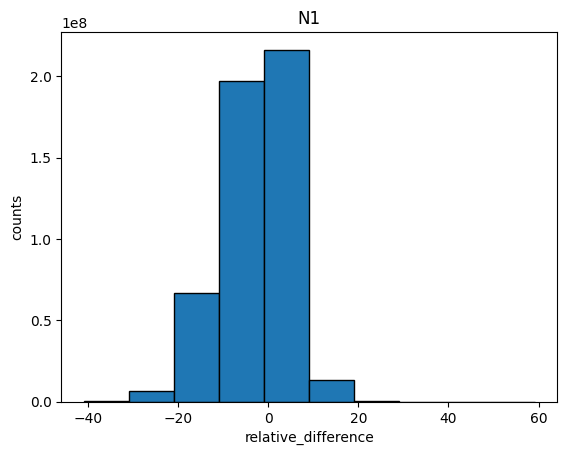

In [59]:
plotHist(N1_cnf, cnfT[0],"N1",0,100)


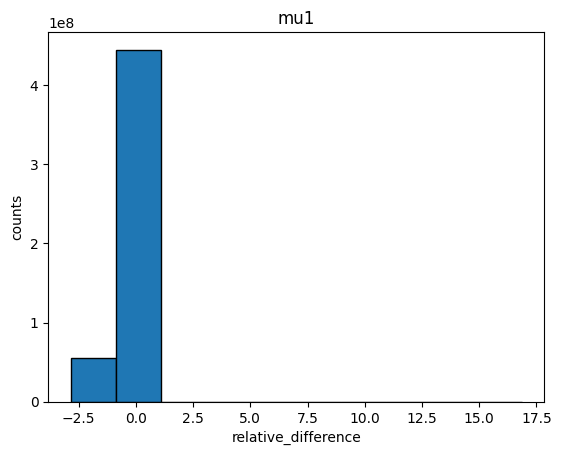

In [60]:
plotHist(mu1_cnf, cnfT[1],"mu1",0,20)

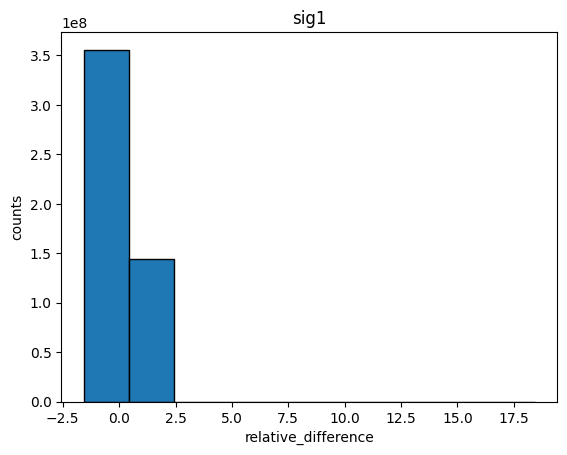

In [61]:
plotHist(sig1_cnf, cnfT[2],"sig1",0,20)

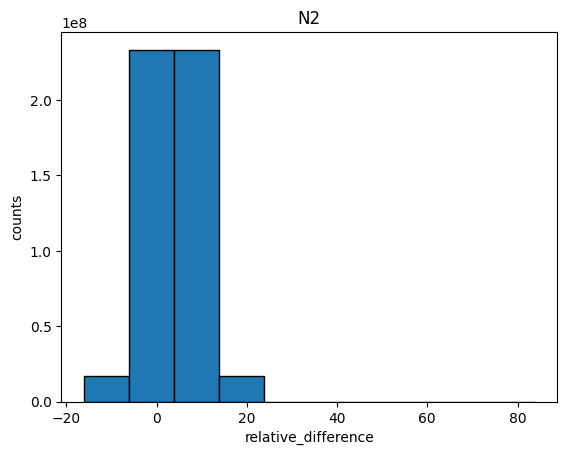

In [62]:
plotHist(N2_cnf, cnfT[3],"N2",0,100)

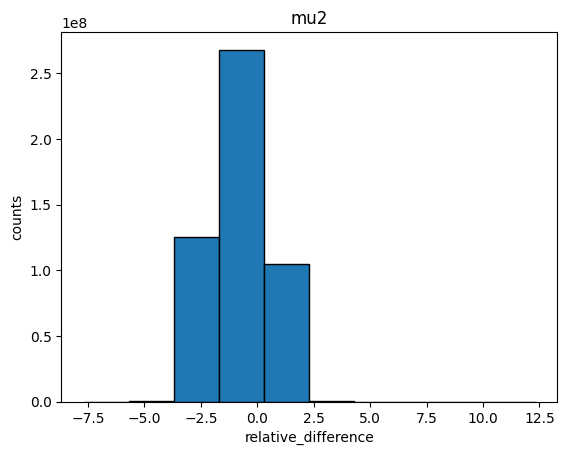

In [63]:
plotHist(mu2_cnf, cnfT[4],"mu2",0,20)

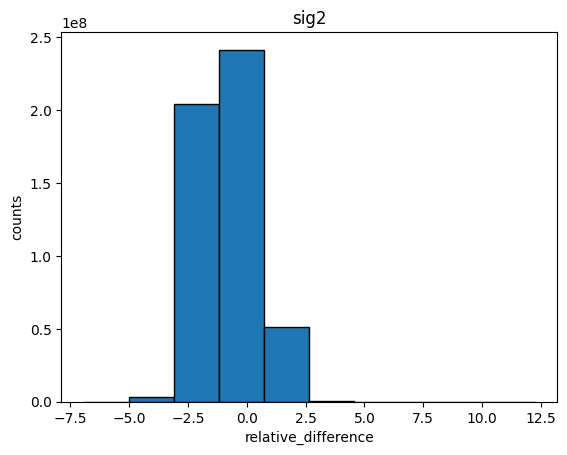

In [64]:
plotHist(sig2_cnf, cnfT[5],"sig2",0,20)

In [53]:
print(len(mu1_cut))

499996365
